# Greenhouse gas benefit from underplanting wildfire-impacted forest stands

Robbie A Hember, PhD, P.Ag.

Last updated: 2020-03-17

Climate Change and Integrated Planning Branch,<br>
Office of the Chief Forester,<br>
Forests Lands, Natural Resource Operations and Rural Development<br>
Government of British Columbia<br>
545 Superior Street, Victoria, Canada<br>
robert.hember@gov.bc.ca

## Introduction

Reforestation of stands that are damaged by wildfires is a major component of land use plans throughout many parts of British Columbia. There are several methods of reforestation of forests, including salvage logging, knocking down and burning, underplanting, and natural regeneration. Underplanting refers to planting areas that require no removal of the overstory. It is primarily applied where the overstory is nearly or completely dead following high-severity wildfires. 

Here, we use Jupyter Notebooks to demonstrate the greenhouse gas (GHG) benefit from the underplanting option in interior and coastal regions of British Columbia. In each regional demonstration, we assume that a severe wildfire occurred in 2017, leading to 100 percent mortality.

As in all climate change mitigation activities, we assess the GHG benefit based on the difference between the GHG balance of the treatment area for a baseline scenario, where the project is not undertaken, and a project scenario, where the underplanting is applied. A positive value of GHG benefit indicates that the project reduced atmospheric GHGs. 

![Trees](https://4cvdc442sefv2px6qf31zwhf-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/16291002_web1_190410-WLT-ForestEnhancementFunding.jpg)
Stands damaged by wildfire in 100 Mile House (www.quesnelobserver.com/news/forest-enhancement-bc-allocates-another-3-4-million-to-improve-damaged-forests/).

Use this button to show or hide the underlying project code.

In [1]:
from IPython.core.display import display, HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show(); }
 code_show = !code_show} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="See code"></form>''')

## Methods

### Prepare session
First let's prepare the session in Jupyter Notebooks and import the required python packages. To do this work, we will use the model <i>cbrunner</i> from the <i>fcgadgets</i> repository. Set how graphic display parameters. Lastly, let's also add a toggle button that will show or ide the code.

In [2]:
# Import modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from fcgadgets.pyscripts import utilities_general as gu
from fcgadgets.pyscripts import utilities_gis as gis
from fcgadgets.cbrunner.cbrun_utilities import *
from fcgadgets.cbrunner.cbrun import *

# Turn warnings off
warnings.filterwarnings('ignore')

# Graphic display parameters
%matplotlib inline
plt.style.use('ggplot')
display(HTML("<style>.container { width:80% !important; } .output {align-items: left; }</style>"))

In [3]:
params_graphic=Import_GraphicsParameters('FCI Demo')
plt.rcParams.update(params_graphic)

### Set stand conditions and disturbance/management events

Begin to set input variables and parameters in the file, ProjectConfig.xlsx. Under the Project Parameters section, adjust the timeframe of the simulation as desired. Set "Biomass Module" to "TIPSY" so that the TASS/TIPSY growth and yield modelling framework (i.e., BatchTIPSY.exe) will be used to drive biomass dynamics. Assume a pre-industrial disturbance regime defined by wildfire and a constant return interval of 150 years. As we will consider the impact of future disturbances, set the number of ensembles, "N Ensemble" to "600".

Under the Scenario Parameters section, start to set scenario-level assumptions. In this section, one specifies the chronology of disturbance/management events that occur in each scenario. Each disturbance or management event is accompanied by a specific growth curve identifier (ID) that will specify the stand conditions for the subsquent regenerating stand.

At the same time, start setting stand conditions for each combination of scenario ID and growth curve ID in the file, GrowthCurvesTIPSY_Parameters.xlsx. 

For the interior region, we will assume that the pre-wildfire stand was 100 percent lodgepole pine with a clumped distribution, site index (SI) of 18 m, and stand density of 1600 stems/hectare. We will assume that the stand was 120 years old when the wildfire occurred in 2017. We will assume that the 2017 wildfire killed 100% of the trees.

As natural regeneration in the baseline scenario is uncertain, we will consider 3 scenarios (1 project and 2 baselines that reflect different levels of natural regeneration):

    1) Baseline scenario - satisfactorily restrocked (SR): 100% lodgepole pine, SI=18 m, N=1800 stems/ha, spatial arrangement=clumped, regen. delay=2 years

    2) Baseline scenario - non-satisfactorily restrocked (NSR): 100% lodgepole pine, SI=18 m, N=200 stems/ha, spatial arrangement=clumped, regen. delay=5 years

    3) Project scenario: 100% lodgepole pine, SI=18 m, N=1800 stems/ha, spatial arrangement=planted, regen. delay=0 years.

For the coastal region, we will assume that the pre-wildfire stand was 100 percent coastal Douglas-fir, natural spatial arrangement, SI = 30 m, and a stand density of 1600 stems/ha. We will assume that the 2017 wildfire killed 100% of the trees. The same 3 types of scenarios will be considered on the coast:

    1) Baseline scenario - satisfactorily restrocked (SR): 100% Douglas-fir, SI=30 m, N=1600 stems/ha, spatial arrangement=natural, regen. delay=2 years

    2) Baseline scenario - non-satisfactorily restrocked (NSR): 100% Douglas-fir, SI=30 m, N=200 stems/ha, spatial arrangement=natural, regen. delay=5 years

    3) Project scenario: 100% Douglas-fir, SI=30 m, N=1600 stems/ha, spatial arrangement=planted, regen. delay=0 years.

There is a signficant chance that these stands will experience more natural disturbances in the future. Assuming that the stands will again experience wildfire in a specific year, say 2042 or 2096, is subjective. Instead, we will represent future disturbance based on simulations that assume a constant annual probability of wildfire. For the interior stand, we will assume a wildfire return interval of 100 years, while in the coastal stand, we will assume a wildfire return interval of 200 years. These are specified in the "Distrubance from Simulation (Future)" section of the "Scenario Parameters" section of ProjectConfig.xlsx. Simulation of future disturbances based on probability introduces a random component to the model predictions. To detect the signal from random noise, we will perform the simulations for each scenario multiple times (i.e., 600 ensembles) and then take the average of the ensembles as the final best estimate.

### Prepare inputs

Begin compiling all the inputs by initializing a dictionary called, meta, and proving the directory path to where the project data, and then importing everything from ProjectConfig.xlsx and GrowthCurvesTIPSY_Parameters.xlsx. All information about the project will be stored in the dictionary, meta.

In [4]:
meta={}
meta['Path Project']=r'G:\My Drive\Data\FCI_Demo_ReforestationUnderplantingWildfire'
meta['Path Model Code']=r'G:\My Drive\Code_Python\fcgadgets\cbrunner'
meta=ImportProjectConfig(meta)

Use the function, <i>BuildTiPSYInputs</i>, to automatically convert the stand parameters in GrowthCurvesTIPSY_Parameters.xlsx to a file that is readable by BatchTIPSY.exe. Then in the BatchTIPSY.exe application, open GrowthCurvesTIPSY_Output.BTP and verify that settings have been specified properly. Then run BatchTIPSY.exe.

In [5]:
BuildTIPSYInputs(meta)

Prepare the inventory file.

In [6]:
for iScn in range(0,meta['N Scenario']):
    
    # Loop through batches, saving inventory to file
    for iBat in range(0,meta['N Batch']):
      
        inv={}
    
        # Index to batch
        iStart=meta['Batch Interval']*iBat
        iStop=np.minimum(meta['N Stand'],iStart+meta['Batch Interval'])
        indBat=np.arange(iStart,iStop,1)    
        N_StandsInBatch=len(indBat)
    
        # Initialize inventory variables
        inv['Lat']=np.zeros((1,N_StandsInBatch))
        inv['Lon']=np.zeros((1,N_StandsInBatch))
        inv['X']=inv['Lat']
        inv['Y']=inv['Lon']
        
        # BEC zone
        inv['ID_BECZ']=meta['LUT BGC Zone']['IDF']*np.ones((1,N_StandsInBatch),dtype=np.int)                  
    
        # Temperature will be updated automatically
        inv['MAT']=4*np.ones((1,N_StandsInBatch))
    
        if meta['Biomass Module']=='Sawtooth':
            inv['Srs1_ID']=meta['LUT Spc'][meta['Scenario'][iScn]['SRS1_CD']]*np.ones((1,N_StandsInBatch),dtype=np.int)
        else:
            inv['Srs1_ID']=9999*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs1_Pct']=100*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs2_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs2_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs3_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs3_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc1_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc1_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc2_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc2_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc3_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc3_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)

        # Save
        gu.opickle(meta['Path Input Scenario'][iScn] + '\\Inventory_Bat' + FixFileNum(iBat) + '.pkl',inv)

Prepare the disturbance/management event file.

In [7]:
for iScn in range(meta['N Scenario']):    
    for iEns in range(meta['N Ensemble']):        
        for iBat in range(meta['N Batch']):
    
            # Index to batch
            iStart=meta['Batch Interval']*iBat
            iStop=np.minimum(meta['N Stand'],iStart+meta['Batch Interval'])
            indBat=np.arange(iStart,iStop,1)
            N_StandsInBatch=len(indBat)
    
            # Build disturbance history for each stand
            eh=list()
            for iStandBat in range(N_StandsInBatch):                
                eh0={}
                
                # Spinup disturbances
                eh0=CompileDisturbancesForSpinup(meta,iScn,eh0)
                
                # Simulated historical disturbances
                eh0=CompileHistoricalDisturbancesFromSimulation(meta,iScn,eh0)
                
                # Disturbance from inventory
                eh0=CompileDisturbancesFromInventory(meta,iScn,eh0) 
            
                # Simulated future disturbances
                eh0=CompileFutureDisturbancesFromSimulation(meta,iScn,eh0)  
            
                # Initialize custom disturbance variables
                for k in range(len(meta['Name CustDistVar'])):
                    eh0[meta['Name CustDistVar'][k]]=np.zeros(eh0['Year'].size,dtype=np.int16)
        
                # Add to Events structure
                eh.append(eh0)

            # Save to file            
            gu.opickle(meta['Path Input Scenario'][iScn] + '\\Disturbance_Ens' + FixFileNum(iEns) + '_Bat' + FixFileNum(iBat) + '.pkl',eh)

Prepare net growth curve files.

In [8]:
PostProcessTIPSY(meta)

### Run the simulation and import results

Run the simulation.

In [9]:
RunProject(meta)

Running Scenario 0001, Ensemble 0001, Batch 0001
12.253336191177368
Running Scenario 0002, Ensemble 0001, Batch 0001
12.135331392288208
Running Scenario 0003, Ensemble 0001, Batch 0001
12.002146482467651
Running Scenario 0004, Ensemble 0001, Batch 0001
12.087349653244019
Running Scenario 0005, Ensemble 0001, Batch 0001
11.963186740875244
Running Scenario 0006, Ensemble 0001, Batch 0001
12.140142440795898


Open the raw output from <i>cbrunner</i> using the function, LoadScenarioResults, and put all the variables in a dictionary, v1. Then use the function, CalculateGHGBalance, to calculate GHG balance from the raw output and put the variables in a dictionary, v2. Lastly open the growth curves output from BatchTIPSY.exe using the function, Import_BatchTIPSY_Output, and put the variables in a dictionary, gc.

In [10]:
v1,meta=LoadScenarioResults(meta)
v2,meta=CalculateGHGBalance(v1,meta)
gc=Import_BatchTIPSY_Output(meta)

## Results

### Ensure that a suffient number of ensembles were included

Recall that we ran 600 ensemble simulations so that we would be able to calculate a smooth average GHG benefit from the full set of ensembles. If we consider too few ensembles, the resulting GHG benefit estimate may be unduely representative of random variation. Let's draw from the results at differnet sampling rates to understand how the number of ensembles, 600, can affect the final result. 

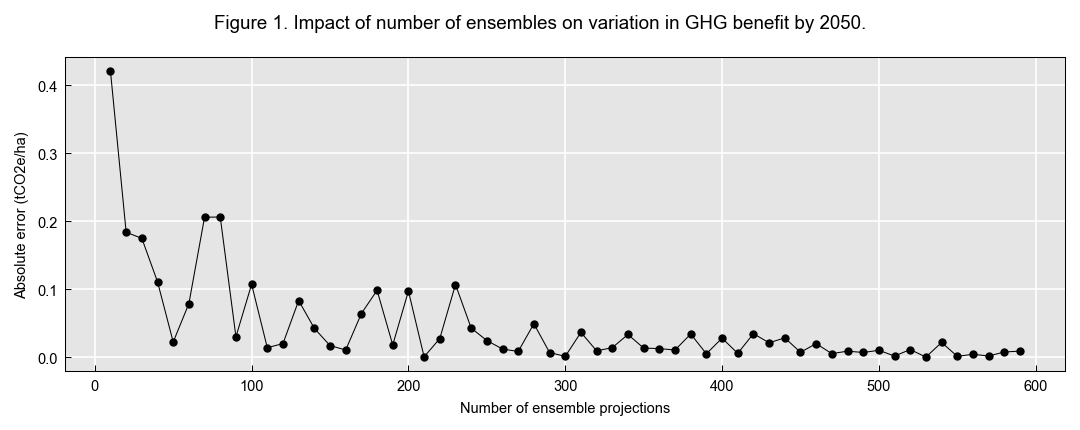

In [14]:
flg=1
if flg==1:
    N=np.arange(10,600,10)
    N_iter=100
    it=np.where(v2[0].Year==2050)[0]
    y=np.zeros((N.size,N_iter))
    for i in range(N_iter):
        for j in range(N.size):
            r=np.random.random((600,1))
            idx=np.argsort(r,axis=0)
            ikp=np.where(idx<=N[j])[0]
            ghgb_ann=np.mean(v2[2].Sec_NGHGB[:,ikp],axis=1)-np.mean(v2[1].Sec_NGHGB[:,ikp],axis=1)
            ghgb_c=np.cumsum(ghgb_ann)
            y[j,i]=ghgb_c[it]
    y=np.mean(y,axis=1)
    fig,ax=plt.subplots(1,figsize=gu.cm2inch(18,7))
    ax.plot(N,np.abs(y-np.mean(y)),'-ko',markersize=3,linewidth=0.5)
    ax.set(ylabel='Absolute error (tCO2e/ha)',
           xlabel='Number of ensemble projections');
    fig.suptitle('Figure 1. Impact of number of ensembles on variation in GHG benefit by 2050.');

From Figure 1, we can see that when the number of ensembles is set to 600, the resulting mean absolute GHG benefit at 250 varies by less than 0.2 tCO2e/ha. As such, we are satisfied that this was a suffient number of ensembles.

### Carbon pools
Let's look at how carbon pools vary among the three scenarios.

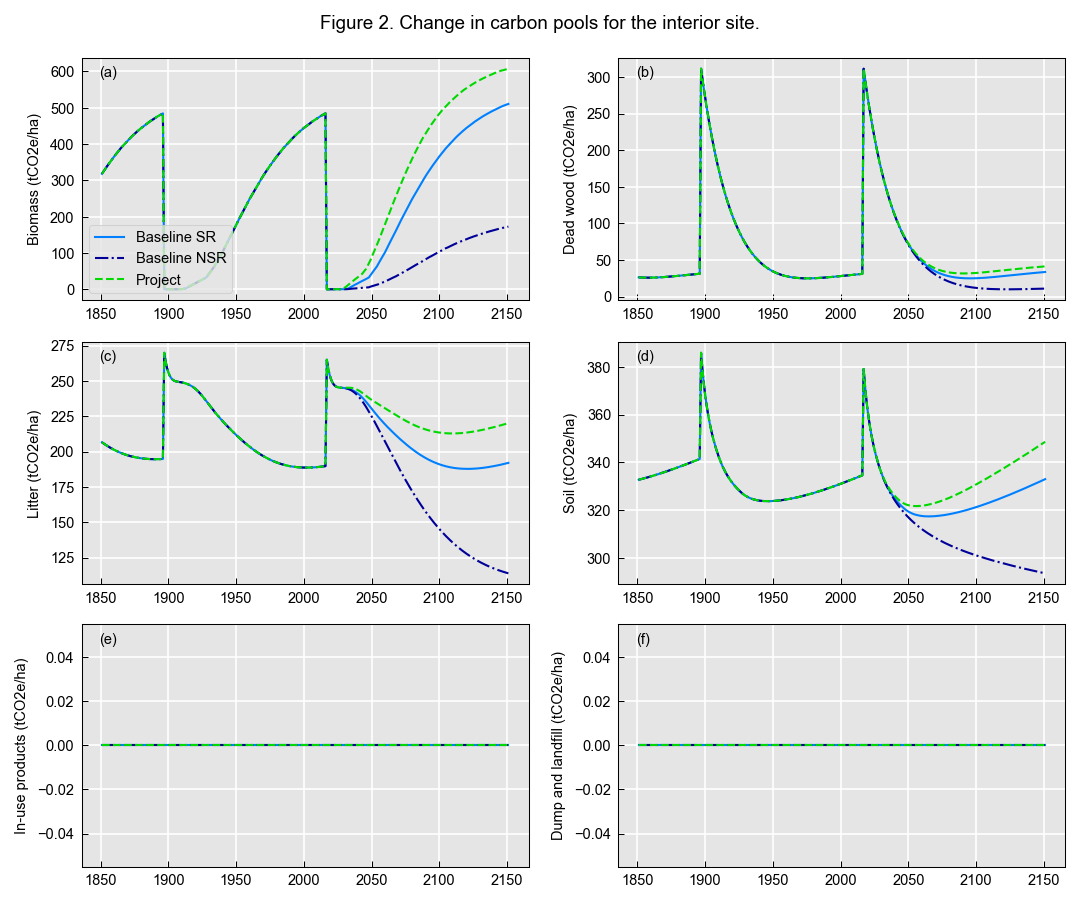

In [16]:
str_var=['Eco_Biomass','Eco_DeadWood','Eco_Litter','Eco_Soil','Pro_InUse','Pro_DumpLandfill']
it=np.where(v2[0].Year>1850)[0]
cnt=0
fig,ax=plt.subplots(3,2,figsize=gu.cm2inch(18,15))
for i in range(3):
    for j in range(2):
        ax[i,j].plot(v2[0].Year[it],np.mean(v2[0][str_var[cnt]][it,:],axis=1),'-',color=(0,0.5,1),linewidth=1,label='Baseline SR')
        ax[i,j].plot(v2[1].Year[it],np.mean(v2[1][str_var[cnt]][it,:],axis=1),'-.',color=(0,0,0.6),linewidth=1,label='Baseline NSR')
        ax[i,j].plot(v2[2].Year[it],np.mean(v2[2][str_var[cnt]][it,:],axis=1),'--',color=(0,0.85,0),linewidth=1,label='Project')
        if (i==0) & (j==0):
            ax[i,j].legend(loc="lower left")
        ax[i,j].set(ylabel=meta['Labels GHG Balance'][str_var[cnt]])
        cnt=cnt+1
fig.suptitle('Figure 2. Change in carbon pools for the interior site.')
gu.axletters(ax,plt,0.04,0.92)

### Impacts on carbon fluxes
Let's look at how carbon fluxes vary among the three scenarios.

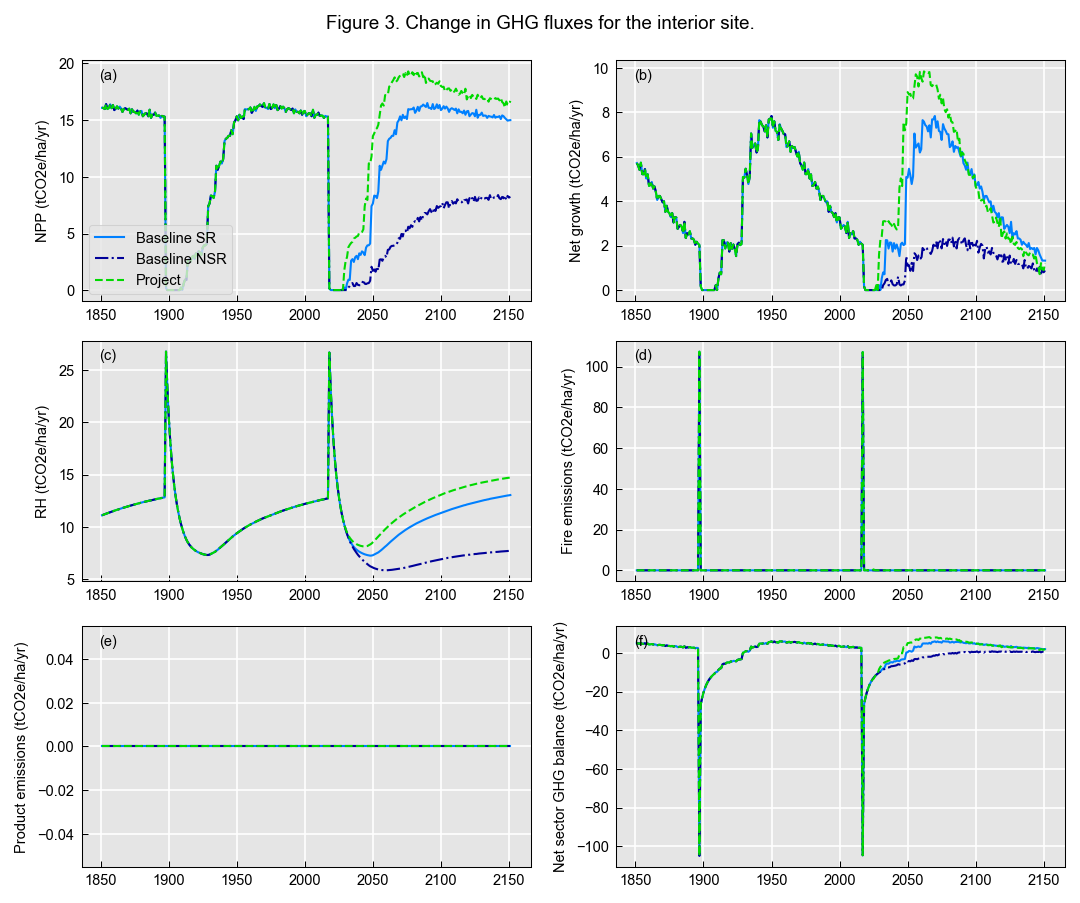

In [17]:
str_var=['Eco_NPP','Eco_G_Net','Eco_RH','Eco_E_Fire','Pro_Emissions','Sec_NGHGB']
it=np.where( (v2[0].Year>1850) )[0]
cnt=0
fig,ax=plt.subplots(3,2,figsize=gu.cm2inch(18,15))
for i in range(3):
    for j in range(2):
        ax[i,j].plot(v2[0].Year[it],np.mean(v2[0][str_var[cnt]][it,:],axis=1),'-',color=(0,0.5,1),linewidth=1,label='Baseline SR')
        ax[i,j].plot(v2[1].Year[it],np.mean(v2[1][str_var[cnt]][it,:],axis=1),'-.',color=(0,0,0.6),linewidth=1,label='Baseline NSR')
        ax[i,j].plot(v2[2].Year[it],np.mean(v2[2][str_var[cnt]][it,:],axis=1),'--',color=(0,0.85,0),linewidth=1,label='Project')
        if (i==0) & (j==0):
            ax[i,j].legend(loc="lower left")
        ax[i,j].set(ylabel=meta['Labels GHG Balance'][str_var[cnt]])
        cnt=cnt+1
fig.suptitle('Figure 3. Change in GHG fluxes for the interior site.')
gu.axletters(ax,plt,0.04,0.92)

### Net sector GHG balance and GHG benefit
Let's look at net sector GHG balance for the scenarios and how this translates into GHG benefit under the two baseline scenarios. 

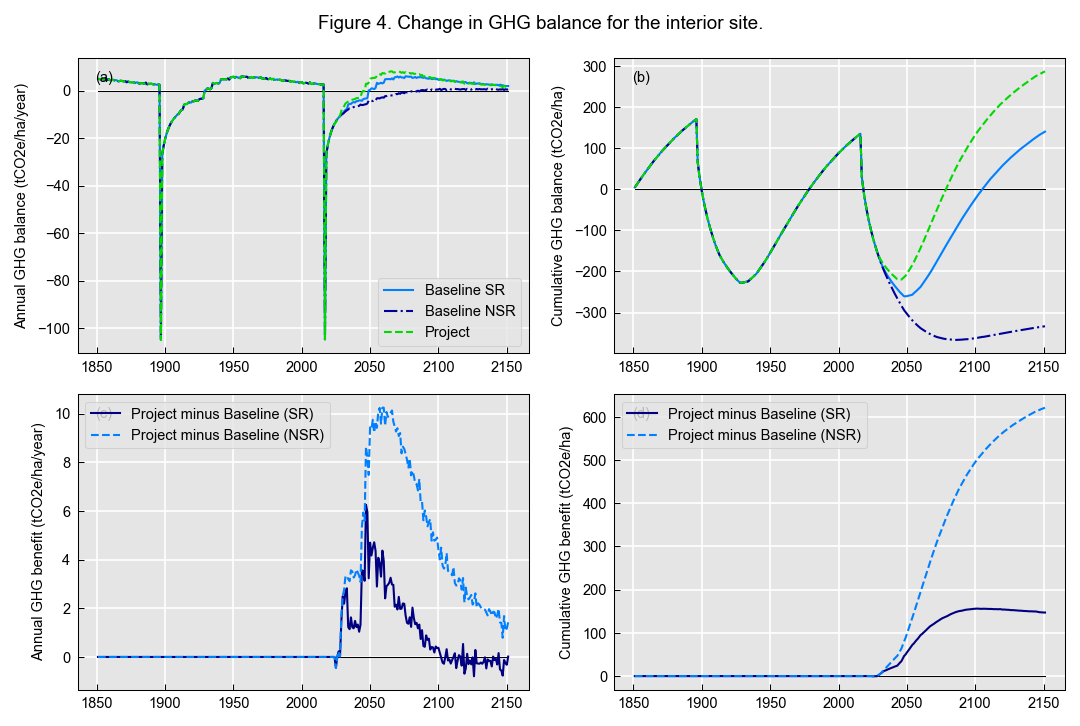

In [18]:
# Plot net sector carbon balance
fig,ax=plt.subplots(2,2,figsize=gu.cm2inch(18,12))
ax[0,0].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].shape),'-',linewidth=0.5,color=(0,0,0))
ax[0,0].plot(v2[0].Year[it],np.mean(v2[0].Sec_NGHGB[it,:],axis=1),'-',color=(0,0.5,1),label='Baseline SR')
ax[0,0].plot(v2[0].Year[it],np.mean(v2[1].Sec_NGHGB[it,:],axis=1),'-.',color=(0,0,0.6),label='Baseline NSR')
ax[0,0].plot(v2[0].Year[it],np.mean(v2[2].Sec_NGHGB[it,:],axis=1),'--',color=(0,0.85,0),label='Project')
ax[0,0].legend(loc="lower right")
ax[0,0].set(ylabel='Annual GHG balance (tCO2e/ha/year)');
ax[0,1].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].shape),'-',linewidth=0.5,color=(0,0,0))
ax[0,1].plot(v2[0].Year[it],np.cumsum(np.mean(v2[0].Sec_NGHGB[it,:],axis=1)),'-',color=(0,0.5,1),label='Baseline SR')
ax[0,1].plot(v2[0].Year[it],np.cumsum(np.mean(v2[1].Sec_NGHGB[it,:],axis=1)),'-.',color=(0,0,0.6),label='Baseline NSR')
ax[0,1].plot(v2[0].Year[it],np.cumsum(np.mean(v2[2].Sec_NGHGB[it,:],axis=1)),'--',color=(0,0.85,0),label='Project')
ax[0,1].set(ylabel='Cumulative GHG balance (tCO2e/ha)');
ax[1,0].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].shape),'-',linewidth=0.5,color=(0,0,0))
ax[1,0].plot(v2[0].Year[it],np.mean(v2[2].Sec_NGHGB[it,:]-v2[0].Sec_NGHGB[it,:],axis=1),'-',color=(0,0,0.5),label='Project minus Baseline (SR)')
ax[1,0].plot(v2[0].Year[it],np.mean(v2[2].Sec_NGHGB[it,:]-v2[1].Sec_NGHGB[it,:],axis=1),'--',color=(0,0.5,1),label='Project minus Baseline (NSR)')
ax[1,0].legend(loc="upper left")
ax[1,0].set(ylabel='Annual GHG benefit (tCO2e/ha/year)');
ax[1,1].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].shape),'-',linewidth=0.5,color=(0,0,0))
ax[1,1].plot(v2[0].Year[it],np.cumsum(np.mean(v2[2].Sec_NGHGB[it,:],axis=1))-np.cumsum(np.mean(v2[0].Sec_NGHGB[it,:],axis=1)),'-',color=(0,0,0.5),label='Project minus Baseline (SR)')
ax[1,1].plot(v2[0].Year[it],np.cumsum(np.mean(v2[2].Sec_NGHGB[it,:],axis=1))-np.cumsum(np.mean(v2[1].Sec_NGHGB[it,:],axis=1)),'--',color=(0,0.5,1),label='Project minus Baseline (NSR)')
ax[1,1].legend(loc="upper left")
ax[1,1].set(ylabel='Cumulative GHG benefit (tCO2e/ha)');
fig.suptitle('Figure 4. Change in GHG balance for the interior site.')
gu.axletters(ax,plt,0.04,0.92)

Finally, let's put the results in tabular format.

In [19]:
df=pd.DataFrame(columns=['Region','Baseline N','Ann. GHG benefit 2030 (tCO2e/ha/yr)','Cumu. GHG benefit 2030 (tCO2e/ha)','Ann. GHG benefit 2050 (tCO2e/ha/yr)','Cumu. GHG benefit 2050 (tCO2e/ha)','Ann. GHG benefit 2080 (tCO2e/ha/yr)','Cumu. GHG benefit 2080 (tCO2e/ha)','Cost ($/ha)','Mitigation Cost ($/tCO2e)'])
df['Region']=['Interior','Interior','Coast','Coast']
df['Baseline N']=['SR','NSR','SR','NSR']

it1=np.where(v2[0].Year==2030)[0];
it2=np.where(v2[0].Year==2050)[0];
it3=np.where(v2[0].Year==2080)[0];

# Interior SR
cnt=0
dA=np.mean(v2[2].Sec_NGHGB-v2[0].Sec_NGHGB,axis=1)
dC=np.cumsum(np.mean(v2[2].Sec_NGHGB-v2[0].Sec_NGHGB,axis=1))
Cost=1800*1.0
dA30=dA[it1][0]; dC30=dC[it1][0]
dA50=dA[it2][0]; dC50=dC[it2][0]
dA80=dA[it3][0]; dC80=dC[it3][0]
df['Ann. GHG benefit 2030 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA30,decimals=1)
df['Cumu. GHG benefit 2030 (tCO2e/ha)'].iloc[cnt]=np.round(dC30,decimals=1)
df['Ann. GHG benefit 2050 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA50,decimals=1)
df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt]=np.round(dC50,decimals=1)
df['Ann. GHG benefit 2080 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA80,decimals=1)
df['Cumu. GHG benefit 2080 (tCO2e/ha)'].iloc[cnt]=np.round(dC80,decimals=1)
df['Cost ($/ha)'].iloc[cnt]=np.round(Cost,decimals=0)
df['Mitigation Cost ($/tCO2e)'].iloc[cnt]=np.round(df['Cost ($/ha)'].iloc[cnt]/df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt],decimals=0)
cnt=cnt+1

# Interior NSR
dA=np.mean(v2[2].Sec_NGHGB-v2[1].Sec_NGHGB,axis=1)
dC=np.cumsum(np.mean(v2[2].Sec_NGHGB-v2[1].Sec_NGHGB,axis=1))
dA30=dA[it1][0]; dC30=dC[it1][0]
dA50=dA[it2][0]; dC50=dC[it2][0]
dA80=dA[it3][0]; dC80=dC[it3][0]
Cost=1800*1.0
df['Ann. GHG benefit 2030 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA30,decimals=1)
df['Cumu. GHG benefit 2030 (tCO2e/ha)'].iloc[cnt]=np.round(dC30,decimals=1)
df['Ann. GHG benefit 2050 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA50,decimals=1)
df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt]=np.round(dC50,decimals=1)
df['Ann. GHG benefit 2080 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA80,decimals=1)
df['Cumu. GHG benefit 2080 (tCO2e/ha)'].iloc[cnt]=np.round(dC80,decimals=1)
df['Cost ($/ha)'].iloc[cnt]=np.round(Cost,decimals=0)
df['Mitigation Cost ($/tCO2e)'].iloc[cnt]=np.round(df['Cost ($/ha)'].iloc[cnt]/df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt],decimals=0)
cnt=cnt+1

# Coast SR
dA=np.mean(v2[5].Sec_NGHGB-v2[3].Sec_NGHGB,axis=1)
dC=np.cumsum(np.mean(v2[5].Sec_NGHGB-v2[3].Sec_NGHGB,axis=1))
dA30=dA[it1][0]; dC30=dC[it1][0]
dA50=dA[it2][0]; dC50=dC[it2][0]
dA80=dA[it3][0]; dC80=dC[it3][0]
Cost=1800*1.3
df['Ann. GHG benefit 2030 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA30,decimals=1)
df['Cumu. GHG benefit 2030 (tCO2e/ha)'].iloc[cnt]=np.round(dC30,decimals=1)
df['Ann. GHG benefit 2050 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA50,decimals=1)
df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt]=np.round(dC50,decimals=1)
df['Ann. GHG benefit 2080 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA80,decimals=1)
df['Cumu. GHG benefit 2080 (tCO2e/ha)'].iloc[cnt]=np.round(dC80,decimals=1)
df['Cost ($/ha)'].iloc[cnt]=np.round(Cost,decimals=0)
df['Mitigation Cost ($/tCO2e)'].iloc[cnt]=np.round(df['Cost ($/ha)'].iloc[cnt]/df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt],decimals=0)
cnt=cnt+1

# Coast NSR
dA=np.mean(v2[5].Sec_NGHGB-v2[4].Sec_NGHGB,axis=1)
dC=np.cumsum(np.mean(v2[5].Sec_NGHGB-v2[4].Sec_NGHGB,axis=1))
dA30=dA[it1][0]; dC30=dC[it1][0]
dA50=dA[it2][0]; dC50=dC[it2][0]
dA80=dA[it3][0]; dC80=dC[it3][0]
Cost=1800*1.3
df['Ann. GHG benefit 2030 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA30,decimals=1)
df['Cumu. GHG benefit 2030 (tCO2e/ha)'].iloc[cnt]=np.round(dC30,decimals=1)
df['Ann. GHG benefit 2050 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA50,decimals=1)
df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt]=np.round(dC50,decimals=1)
df['Ann. GHG benefit 2080 (tCO2e/ha/yr)'].iloc[cnt]=np.round(dA80,decimals=1)
df['Cumu. GHG benefit 2080 (tCO2e/ha)'].iloc[cnt]=np.round(dC80,decimals=1)
df['Cost ($/ha)'].iloc[cnt]=np.round(Cost,decimals=0)
df['Mitigation Cost ($/tCO2e)'].iloc[cnt]=np.round(df['Cost ($/ha)'].iloc[cnt]/df['Cumu. GHG benefit 2050 (tCO2e/ha)'].iloc[cnt],decimals=0)
cnt=cnt+1
df

,Region,Baseline N,Ann. GHG benefit 2030 (tCO2e/ha/yr),Cumu. GHG benefit 2030 (tCO2e/ha),Ann. GHG benefit 2050 (tCO2e/ha/yr),Cumu. GHG benefit 2050 (tCO2e/ha),Ann. GHG benefit 2080 (tCO2e/ha/yr),Cumu. GHG benefit 2080 (tCO2e/ha),Cost ($/ha),Mitigation Cost ($/tCO2e)
0,Interior,SR,2.5,3.8,4.7,54.6,1.2,139.6,1800,33
1,Interior,NSR,2.5,4,9.4,97.6,7.5,376.4,1800,18
2,Coast,SR,5.2,11.4,-0.1,151.2,-0.1,178.3,2340,15
3,Coast,NSR,4.4,6.5,13.9,301.5,4.8,562.4,2340,8


## Acknowledgements

This work was supported by Canada's Low Carbon Economy Leadership Fund (https://www.canada.ca/en/environment-climate-change/services/climate-change/low-carbon-economy-fund.html).